In [1]:
import os, sys, json, math, glob, subprocess, itertools, warnings
warnings.filterwarnings("ignore")

import numpy as np
import awkward as ak
import uproot
from typing import Any, Dict, Sequence, Tuple, Optional
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, MaxNLocator
import gc

import mplhep as hep
hep.style.use("CMS")

In [2]:
base = "/eos/cms/store/group/dpg_hgcal/tb_hgcal/2025/SepTestBeam2025/"
muonRuns = ["112146", "112147", "112148", "112149"]
BRANCHES = [
    "run", "event",
    "nHGCHit","HGCHit_x","HGCHit_y","HGCHit_z",
    "HGCHit_energy","HGCHit_nmips",
    "HGCHit_layer","HGCHit_zSide","HGCHit_flags",
]

# /eos/cms/store/group/dpg_hgcal/tb_hgcal/2025/SepTestBeam2025/Run112149/af849ba4-a3dc-11f0-a638-04d9f5f94829/prompt/


In [3]:
def find_nano_files(base, runs_list, max_per_run=None):
    files = []
    for r in runs_list:
        run_dir = os.path.join(base, f"Run{r}")
        cand = sorted(glob.glob(os.path.join(run_dir, "**", "prompt", "NANO_*.root"), recursive=True))
        if max_per_run is not None:
            cand = cand[:max_per_run]
        files.extend(cand)
    return files

def find_nano_files_grouped(base, runs_list, max_per_run=None):
    by_run = {}
    for r in runs_list:
        run_dir = os.path.join(base, f"Run{r}")
        cand = sorted(glob.glob(os.path.join(run_dir, "**", "prompt", "NANO_*.root"),
                                recursive=True))
        if max_per_run is not None:
            cand = cand[:max_per_run]
        by_run[str(r)] = cand
    return by_run


In [4]:
def load_hits_iter(files, branches, step_size=5000):
    xs, ys, zs, Es, nMIPS, layers, zside, flags, nHits = [], [], [], [], [], [], [], [], []

    file_map = {f: "Events" for f in files}

    for arr in uproot.iterate(
        file_map,
        branches,
        step_size=step_size,
        library="ak"
    ):
        xs.append(arr["HGCHit_x"])
        ys.append(arr["HGCHit_y"])
        zs.append(arr["HGCHit_z"])
        Es.append(arr["HGCHit_energy"])
        nMIPS.append(arr["HGCHit_nmips"])
        layers.append(arr["HGCHit_layer"])
        zside.append(arr["HGCHit_zSide"])
        flags.append(arr["HGCHit_flags"])
        nHits.append(arr["nHGCHit"])

    # flatten everything into one dictionary
    return {
        "x": ak.concatenate(xs),
        "y": ak.concatenate(ys),
        "z": ak.concatenate(zs),
        "E": ak.concatenate(Es),
        "nMIPS": ak.concatenate(nMIPS),
        "layer": ak.concatenate(layers),
        "zside": ak.concatenate(zside),
        "flags": ak.concatenate(flags),
        "nHits": ak.concatenate(nHits),
    }

files = find_nano_files(base, muonRuns)
data = load_hits_iter(files[:100], BRANCHES, step_size=5000)
print("Loaded:", len(data["x"]), "hits total")

def load_hits_iter_by_run(
    files,
    step_size="40 MB",
    drop_layer=10,
    keep_full=False,
    roi=None,             
):
    by_run = {}
    file_map = {f: "Events" for f in files}

    for arr in uproot.iterate(file_map, BRANCHES, library="ak", step_size=step_size):
        run_evt = arr["run"]
        xj = arr["HGCHit_x"]
        run_hits = ak.broadcast_arrays(run_evt, xj)[0]

        # flatten
        x = ak.to_numpy(ak.flatten(arr["HGCHit_x"])).astype(np.float64)
        y = ak.to_numpy(ak.flatten(arr["HGCHit_y"])).astype(np.float64)
        E = ak.to_numpy(ak.flatten(arr["HGCHit_energy"])).astype(np.float64)
        L = ak.to_numpy(ak.flatten(arr["HGCHit_layer"])).astype(np.int32)
        fl= ak.to_numpy(ak.flatten(arr["HGCHit_flags"]))
        run = ak.to_numpy(ak.flatten(run_hits)).astype(np.int64)

        m = (
            np.isfinite(x) & np.isfinite(y) & np.isfinite(E) &
            np.isfinite(L) & (fl == 0) & (L != drop_layer)
        )
        if roi is not None:
            x0,x1,y0,y1 = roi
            m &= (x > x0) & (x < x1) & (y > y0) & (y < y1)

        if not np.any(m):
            continue
        x,y,E,L,run = x[m],y[m],E[m],L[m],run[m]

        # group by run
        for r in np.unique(run):
            selr = (run == r)
            if not np.any(selr): 
                continue
            key = str(int(r))

            xr, yr, Er, Lr = x[selr], y[selr], E[selr], L[selr]
            is_front = (Lr % 2 == 1)
            is_back  = ~is_front

            if keep_full:
                d = {"x": xr, "y": yr, "E": Er, "L": Lr}
                if key in by_run:
                    for k in d:
                        by_run[key][k] = np.concatenate([by_run[key][k], d[k]])
                else:
                    by_run[key] = d
                continue

            acc = by_run.setdefault(key, {})

            Lf = Lr[is_front]
            if Lf.size:
                for Lk in np.unique(Lf):
                    mL = is_front & (Lr == Lk)
                    if not np.any(mL): continue
                    w = Er[mL]; sw = w.sum()
                    if sw <= 0: continue
                    sx = np.sum(w * xr[mL]); sy = np.sum(w * yr[mL])
                    slot = acc.setdefault(("front", int(Lk)), [0.0, 0.0, 0.0, 0])
                    slot[0] += sx; slot[1] += sy; slot[2] += sw; slot[3] += int(np.count_nonzero(mL))

            # accumulate per layer for Back (even)
            Lb = Lr[is_back]
            if Lb.size:
                for Lk in np.unique(Lb):
                    mL = is_back & (Lr == Lk)
                    if not np.any(mL): continue
                    w = Er[mL]; sw = w.sum()
                    if sw <= 0: continue
                    sx = np.sum(w * xr[mL]); sy = np.sum(w * yr[mL])
                    slot = acc.setdefault(("back", int(Lk)), [0.0, 0.0, 0.0, 0])
                    slot[0] += sx; slot[1] += sy; slot[2] += sw; slot[3] += int(np.count_nonzero(mL))

        del arr, run_hits
        gc.collect()

    # finalize to recarrays if not keeping full hits
    if not keep_full:
        out = {}
        dt = [('L',int),('xc',float),('yc',float),('N',int),('W',float)]
        for r, acc in by_run.items():
            F, B = [], []
            for (side, Lk), (sx, sy, sw, N) in acc.items():
                if sw <= 0: continue
                row = (int(Lk), sx/sw, sy/sw, int(N), float(sw))
                (F if side == "front" else B).append(row)
            F.sort(key=lambda t: t[0]); B.sort(key=lambda t: t[0])
            out[r] = {
                "front": np.array(F, dtype=dt),
                "back":  np.array(B, dtype=dt),
                "all":   np.array(F + B, dtype=dt),
            }
        return out

    return by_run



Loaded: 417039 hits total


In [5]:
def event_level_metrics_chunk(arr, roi, drop_layer):
    x0,x1,y0,y1 = roi

    X  = arr["HGCHit_x"]
    Y  = arr["HGCHit_y"]
    E  = arr["HGCHit_energy"]
    M  = arr["HGCHit_nmips"]
    L  = arr["HGCHit_layer"]
    FL = arr["HGCHit_flags"]

    good   = (np.isfinite(X) & np.isfinite(Y) &
              np.isfinite(E) & np.isfinite(M) &
              np.isfinite(L) & (L != drop_layer) & (FL == 0))
    in_roi = (X > x0) & (X < x1) & (Y > y0) & (Y < y1)
    Hmask  = good & in_roi

    nHits   = ak.sum(Hmask, axis=-1)
    sumMIPs = ak.sum(ak.where(Hmask, M, 0), axis=-1)
    sumE    = ak.sum(ak.where(Hmask, E, 0), axis=-1)

    return Hmask, nHits, sumMIPs, sumE

def event_metrics(files, roi=(80,100,60,80), drop_layer=10, step_size="40 MB"):
    x0,x1,y0,y1 = roi
    file_map = {f: "Events" for f in files}
    out = dict(run=[], nHits=[], sumMIPs=[], sumE=[], maxMIPs=[])
    for arr in uproot.iterate(file_map, BRANCHES, step_size=step_size, library="ak"):
        X=arr["HGCHit_x"]; Y=arr["HGCHit_y"]; E=arr["HGCHit_energy"]; M=arr["HGCHit_nmips"]
        L=arr["HGCHit_layer"]; FL=arr["HGCHit_flags"]
        good   = (np.isfinite(X)&np.isfinite(Y)&np.isfinite(E)&np.isfinite(M)&np.isfinite(L)&(L!=drop_layer)&(FL==0))
        in_roi = (X>x0)&(X<x1)&(Y>y0)&(Y<y1)
        m = good & in_roi
        n_hits_roi     = ak.sum(m, axis=-1)
        sum_nmips_roi  = ak.sum(ak.where(m, M, 0), axis=-1)
        sum_energy_roi = ak.sum(ak.where(m, E, 0), axis=-1)
        max_nmips_roi  = ak.max(ak.where(m, M, -np.inf), axis=-1)
        max_nmips_roi  = ak.where(np.isfinite(max_nmips_roi), max_nmips_roi, 0)

        out["run"].append(arr["run"])
        out["nHits"].append(n_hits_roi)
        out["sumMIPs"].append(sum_nmips_roi)
        out["sumE"].append(sum_energy_roi)
        out["maxMIPs"].append(max_nmips_roi)

    for k in out:
        out[k] = ak.to_numpy(ak.concatenate(out[k], axis=0))
    return out

In [6]:
nHits_max    = 12
sumMIPs_max  = 50

def muon_event_mask(nHits, sumMIPs, nHits_max, sumMIPs_max):
    return (nHits <= nHits_max) & (sumMIPs <= sumMIPs_max)


def accumulate_centroids_for_hits(acc, X, Y, E, L, run_arr, ev_keep, Hmask, dx_dict=None, dy_dict=None,):
    ev_keep_hits = ak.broadcast_arrays(ev_keep, X)[0]
    run_hits     = ak.broadcast_arrays(run_arr, X)[0]

    use = Hmask & ev_keep_hits
    if ak.sum(use) == 0:
        return

    Xs = ak.flatten(X[use]);  Ys = ak.flatten(Y[use])
    Es = ak.flatten(E[use]);  Ls = ak.flatten(L[use])
    Rs = ak.flatten(run_hits[use])

    Xs, Ys, Es, Ls, Rs = map(ak.to_numpy, (Xs, Ys, Es, Ls, Rs))
    if Xs.size == 0:
        return
    
    # compute corrections
    if dx_dict is not None:
        dxL = np.frompyfunc(lambda l: float(dx_dict.get(int(l), 0.0)), 1, 1)(Ls).astype(float)
        Xs = Xs + dxL
    if dy_dict is not None:
        dyL = np.frompyfunc(lambda l: float(dy_dict.get(int(l), 0.0)), 1, 1)(Ls).astype(float)
        Ys = Ys + dyL

    for r in np.unique(Rs):
        mr = (Rs == r)
        if not mr.any():
            continue
        key = str(int(r))
        bucket = acc.setdefault(key, {})

        xr, yr, er, lr = Xs[mr], Ys[mr], Es[mr], Ls[mr]

        # front
        mf = (lr % 2 == 1)
        if mf.any():
            for Lk in np.unique(lr[mf]):
                mL = (lr == Lk) & mf
                w = er[mL]; sw = w.sum()
                if sw > 0:
                    sx = (w * xr[mL]).sum(); sy = (w * yr[mL]).sum()
                    slot = bucket.setdefault(("front", int(Lk)), [0.0, 0.0, 0.0, 0])
                    slot[0] += sx; slot[1] += sy; slot[2] += sw; slot[3] += int(mL.sum())

        # back 
        mb = ~mf
        if mb.any():
            for Lk in np.unique(lr[mb]):
                mL = (lr == Lk) & mb
                w = er[mL]; sw = w.sum()
                if sw > 0:
                    sx = (w * xr[mL]).sum(); sy = (w * yr[mL]).sum()
                    slot = bucket.setdefault(("back", int(Lk)), [0.0, 0.0, 0.0, 0])
                    slot[0] += sx; slot[1] += sy; slot[2] += sw; slot[3] += int(mL.sum())

def centroids(by_run_acc):
    out = {}
    for r, acc in by_run_acc.items():
        rowsF, rowsB = [], []
        for (side, Lk), (sx, sy, sw, N) in acc.items():
            if sw <= 0:
                continue
            if side == "front":
                rowsF.append((int(Lk), sx/sw, sy/sw, int(N), float(sw)))
            else:
                rowsB.append((int(Lk), sx/sw, sy/sw, int(N), float(sw)))

        rowsF.sort(key=lambda t: t[0])
        rowsB.sort(key=lambda t: t[0])

        def rows_to_dict(rows):
            if not rows:
                return {"L": np.array([], int),
                        "xc": np.array([]), "yc": np.array([]),
                        "N": np.array([], int), "W": np.array([])}
            A = np.asarray(rows, dtype=float)
            return {
                "L":  A[:, 0].astype(int),
                "xc": A[:, 1],
                "yc": A[:, 2],
                "N":  A[:, 3].astype(int),
                "W":  A[:, 4],
            }

        F = rows_to_dict(rowsF)
        B = rows_to_dict(rowsB)

        if F["L"].size or B["L"].size:
            L_all  = np.concatenate([F["L"],  B["L"]])
            xc_all = np.concatenate([F["xc"], B["xc"]])
            yc_all = np.concatenate([F["yc"], B["yc"]])
            N_all  = np.concatenate([F["N"],  B["N"]])
            W_all  = np.concatenate([F["W"],  B["W"]])
            ordL   = np.argsort(L_all)
            ALL = {
                "L":  L_all[ordL],
                "xc": xc_all[ordL],
                "yc": yc_all[ordL],
                "N":  N_all[ordL],
                "W":  W_all[ordL],
            }
        else:
            ALL = {"L": np.array([], int), "xc": np.array([]), "yc": np.array([]),
                   "N": np.array([], int), "W": np.array([])}

        out[str(r)] = {"front": F, "back": B, "all": ALL}

    assert isinstance(out, dict), f"centroids() must return dict, got {type(out)}"
    return out


def collect_muons_and_centroids(
    files,
    roi=(50,100,50,100),
    drop_layer=10,
    step_size="40 MB",
    keep_event_ids=True,
    dx_dict=None, dy_dict=None,
):
    file_map = {f: "Events" for f in files}
    by_run_acc = {}
    accepted_events = {} if keep_event_ids else None

    for arr in uproot.iterate(file_map, BRANCHES, library="ak", step_size=step_size):
        # per-event masks inside ROI
        Hmask, nHits, sumMIPs, _ = event_level_metrics_chunk(arr, roi, drop_layer)

        # muon mask
        ev_keep = muon_event_mask(nHits, sumMIPs, nHits_max=nHits_max, sumMIPs_max=sumMIPs_max)

        # accumulate centroids from *accepted* events only
        accumulate_centroids_for_hits(
            by_run_acc,
            arr["HGCHit_x"], arr["HGCHit_y"], arr["HGCHit_energy"], arr["HGCHit_layer"],
            arr["run"], ev_keep, Hmask,
            dx_dict=dx_dict, dy_dict=dy_dict,
        )

        if keep_event_ids:
            rr = ak.to_numpy(arr["run"][ev_keep])
            ee = ak.to_numpy(arr["event"][ev_keep])
            for r_, e_ in zip(rr, ee):
                key = str(int(r_))
                accepted_events.setdefault(key, []).append(int(e_))

    C_by_run = centroids(by_run_acc)

    if keep_event_ids:
        for k, v in accepted_events.items():
            accepted_events[k] = np.array(sorted(set(v)), dtype=np.int64)

    return C_by_run, accepted_events


In [7]:
def plot_centroids_runs(C_by_run, side="front"):
    fig, ax = plt.subplots()
    for r, C in C_by_run.items():
        A = C.get(side, {})
        if not A or A["xc"].size == 0:
            continue
        ax.plot(A["xc"], A["yc"], 'o', label=f"Run {r}")
    ax.set_xlabel("centroid x [mm]"); ax.set_ylabel("centroid y [mm]")
    ax.text(0.3,0.6, f"{side}", transform=ax.transAxes,)
    ax.legend()

In [8]:
mu_ctrl = event_metrics(files[:100], roi=(50,100,50,100), drop_layer=10)


nHits_max, sumMIPs_max = 12, 50
mu_mask = (mu_ctrl["nHits"] <= nHits_max) & (mu_ctrl["sumMIPs"] <= sumMIPs_max)

print(mu_mask)
print(f"Muon-like fraction: {100*mu_mask.mean():.1f}%")


[False False False ... False False  True]
Muon-like fraction: 11.7%


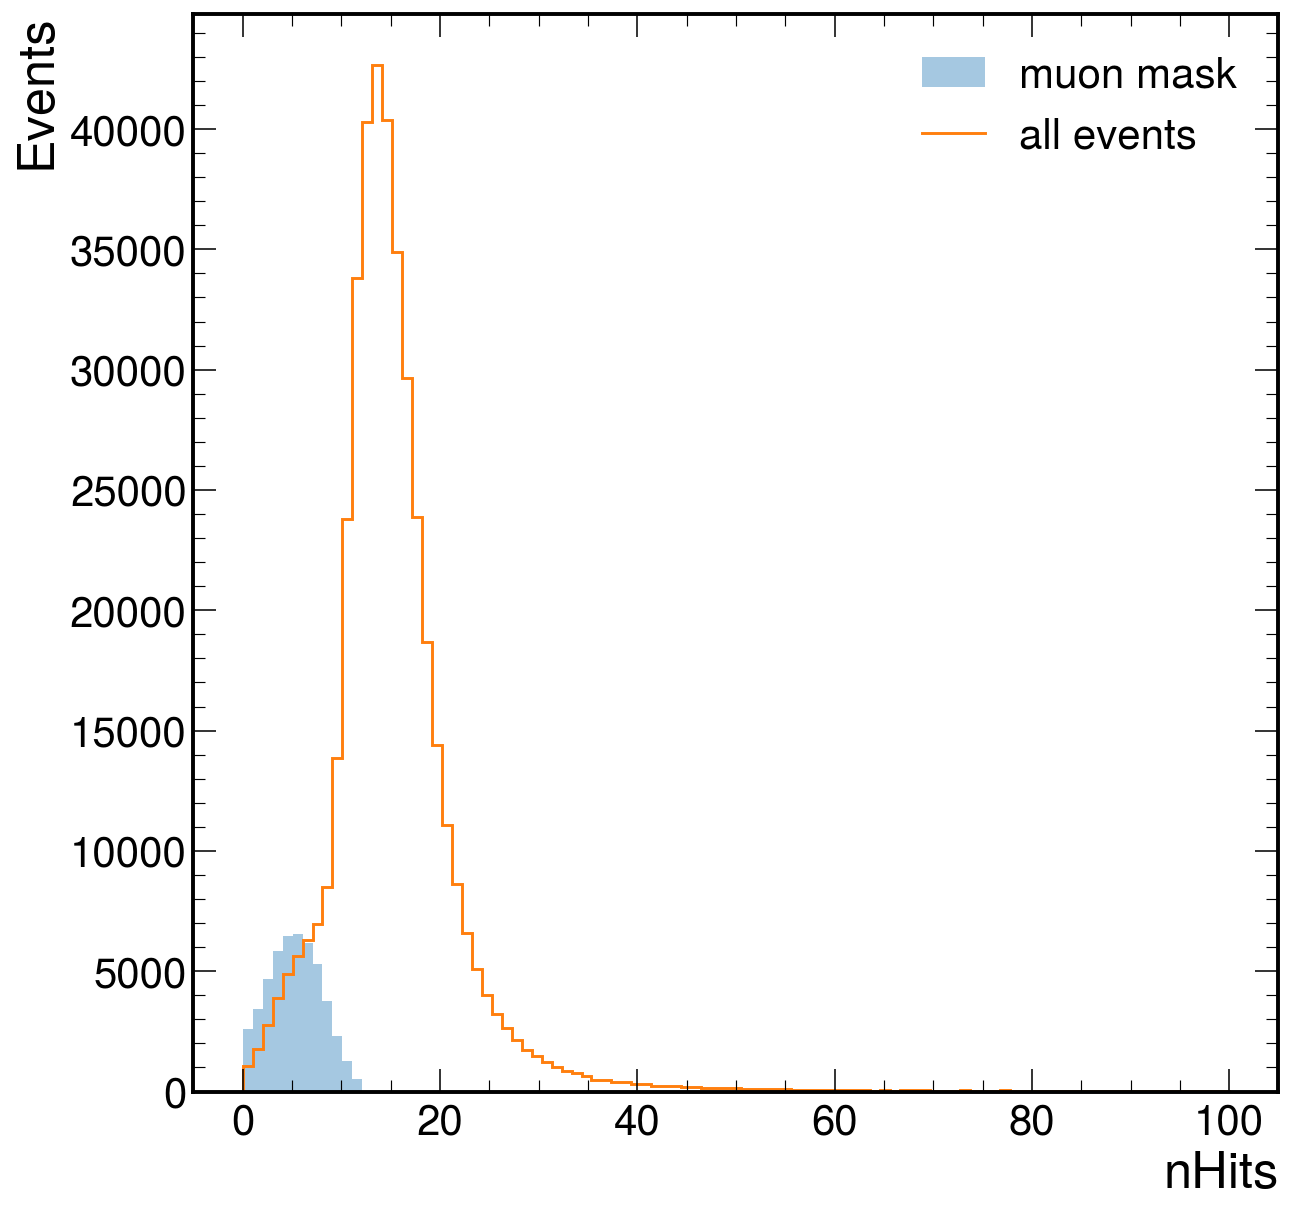

In [9]:
edges = np.linspace(0, 100, 100)
c1, b1 = np.histogram(np.asarray(mu_ctrl['nHits'][mu_mask]), bins=edges)
c2, b2 = np.histogram(np.asarray(data['nHits']),                   bins=edges)

fig, ax = plt.subplots(dpi=140)
hep.histplot(c1, bins=b1, ax=ax, label="muon mask", histtype="fill", alpha=0.4)
hep.histplot(c2, bins=b2, ax=ax, label="all events", histtype="step")
ax.set_xlabel("nHits"); ax.set_ylabel("Events")
ax.legend(frameon=False)
plt.show()

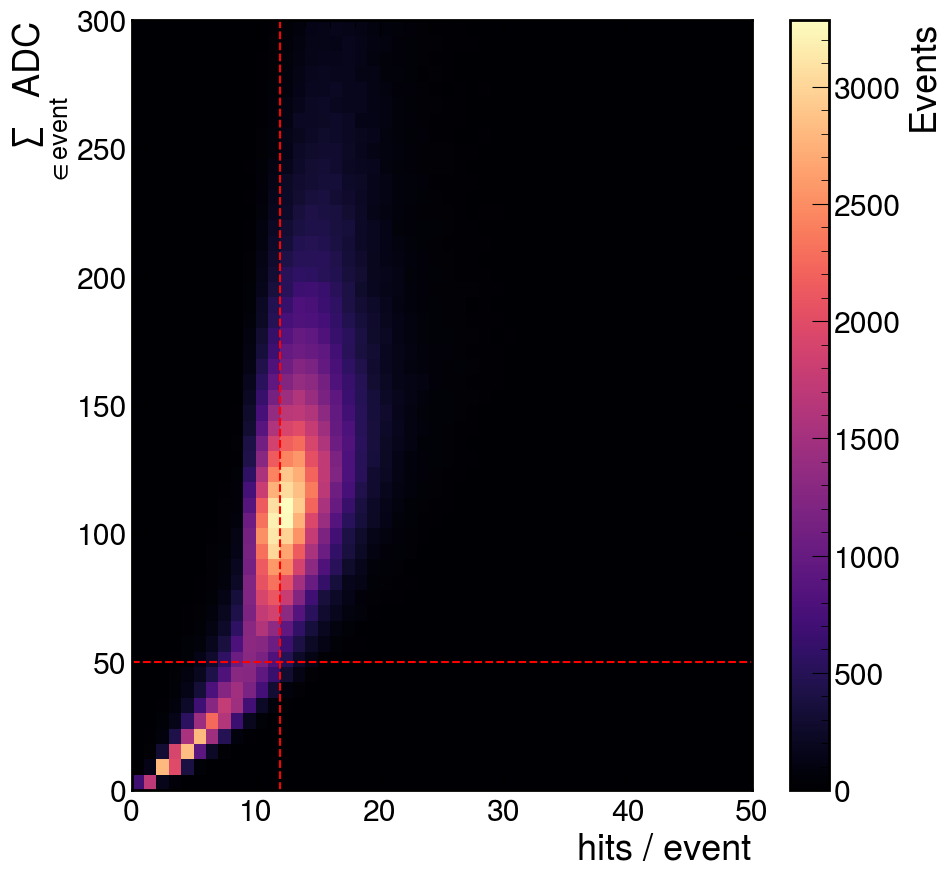

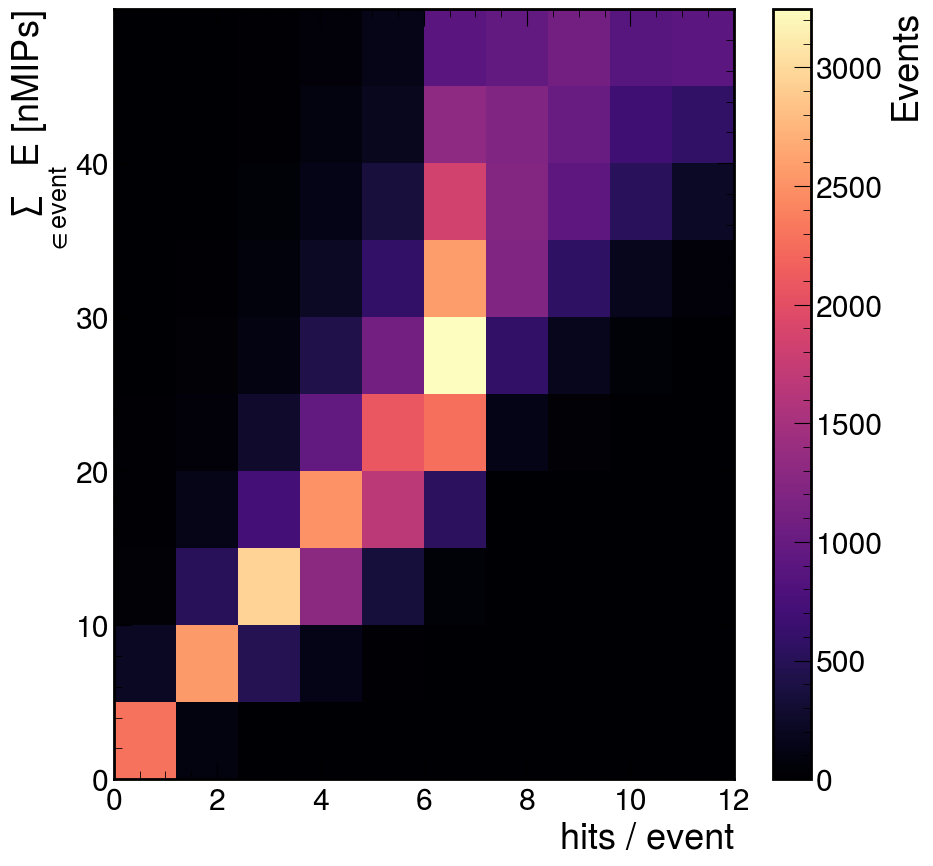

In [10]:
fig, ax = plt.subplots()
plt.hist2d(mu_ctrl["nHits"], mu_ctrl["sumMIPs"], bins=(50,50),
           range=((0,50),(0,300)), cmap="magma")
plt.axvline(12, color="r", ls="--")
plt.axhline(50, color="r", ls="--")
plt.xlabel("hits / event")
plt.ylabel(r"$\sum_{\in \rm event} ADC$")
plt.colorbar(label="Events")
plt.show()

plt.hist2d(mu_ctrl["nHits"][mu_mask], mu_ctrl["sumMIPs"][mu_mask], bins=(10,10), cmap="magma")
plt.xlabel("hits / event")
plt.ylabel(r"$\sum_{\in \rm event} E$ [nMIPs]")
plt.colorbar(label="Events")


In [11]:
runs = ["112147","112148","112149"]
by_run_files = find_nano_files_grouped(base, runs, max_per_run=10)
all_files = [f for files in by_run_files.values() for f in files]

C_by_run, accepted_by_run = collect_muons_and_centroids(
    all_files, roi=(50,100,50,100), step_size="40 MB", keep_event_ids=True
)

for r, ev in accepted_by_run.items():
    print(f"Run {r}: kept {ev.size} events")


Run 112147: kept 5297 events
Run 112148: kept 9045 events
Run 112149: kept 5220 events


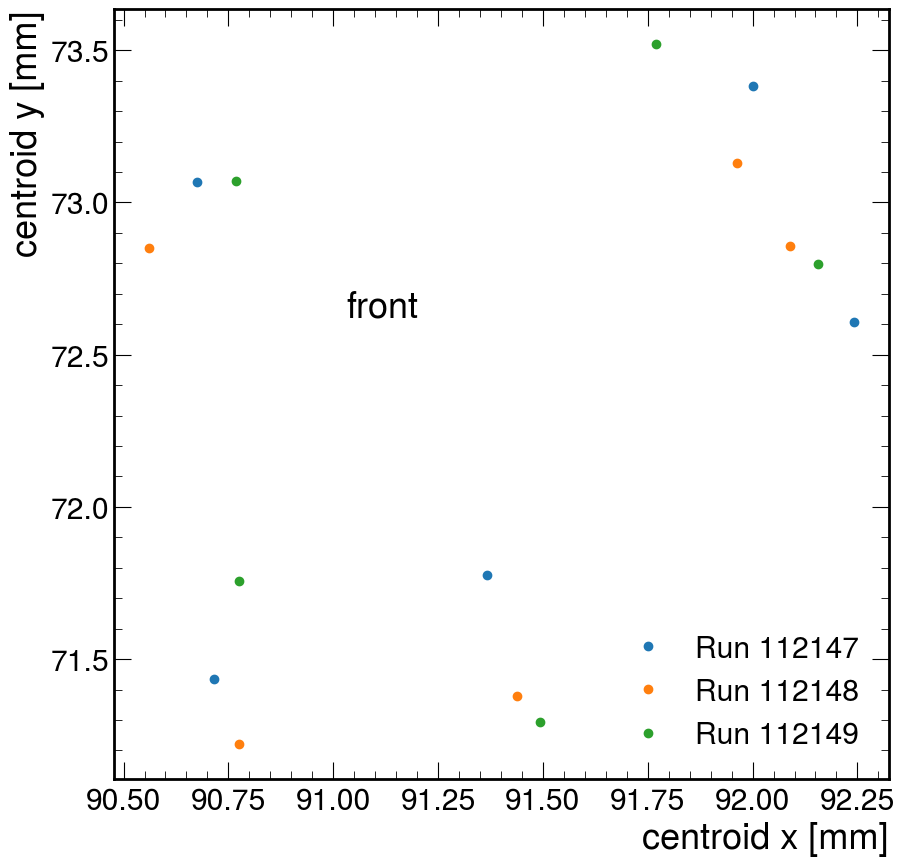

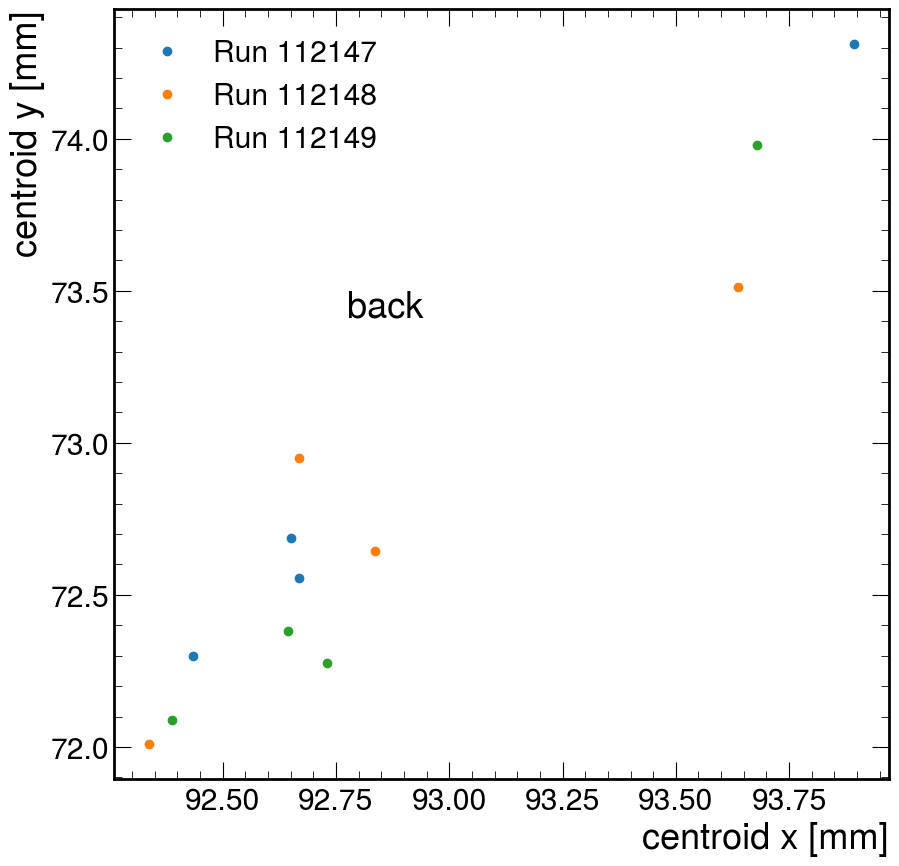

In [12]:
plot_centroids_runs(C_by_run, side='front')
plot_centroids_runs(C_by_run, side='back')

In [13]:
def muon_hits_in_roi(
    files,
    roi=(50,100,50,100),
    drop_layer=10,
    step_size="40 MB",
    run_whitelist=None,
):
    file_map = {f: "Events" for f in files}
    Xs, Ys, Es, Ls = [], [], [], []

    for arr in uproot.iterate(file_map, BRANCHES, library="ak", step_size=step_size):
        if run_whitelist is not None:
            runs = ak.to_numpy(arr["run"])
            keep_run = np.isin(runs.astype(int), np.fromiter(map(int, run_whitelist), dtype=int))
            if not np.any(keep_run):
                continue
            # mask events to selected runs
            ev_mask_runs = ak.Array(keep_run)
            for k in ["HGCHit_x","HGCHit_y","HGCHit_energy","HGCHit_nmips","HGCHit_layer","HGCHit_flags"]:
                arr[k] = arr[k][ev_mask_runs]
            arr["run"]   = arr["run"][ev_mask_runs]
            arr["event"] = arr["event"][ev_mask_runs]

        Hmask, nHits, sumMIPs, _ = event_level_metrics_chunk(arr, roi, drop_layer)

        # muon mask
        ev_keep = muon_event_mask(nHits, sumMIPs, nHits_max, sumMIPs_max)

        # apply event mask at hit-level
        ev_keep_hits = ak.broadcast_arrays(ev_keep, arr["HGCHit_x"])[0]
        good_hits = Hmask & ev_keep_hits

        if ak.sum(good_hits) == 0:
            continue

        # flatten selected hits
        Xs.append(ak.to_numpy(ak.flatten(arr["HGCHit_x"][good_hits])))
        Ys.append(ak.to_numpy(ak.flatten(arr["HGCHit_y"][good_hits])))
        Es.append(ak.to_numpy(ak.flatten(arr["HGCHit_energy"][good_hits])))
        Ls.append(ak.to_numpy(ak.flatten(arr["HGCHit_layer"][good_hits])))

        del arr, Hmask, nHits, sumMIPs, ev_keep, ev_keep_hits, good_hits
        gc.collect()

    if not Xs:
        return dict(x=np.array([]), y=np.array([]), E=np.array([]), L=np.array([]))

    # concatenate across chunks
    x = np.concatenate(Xs); y = np.concatenate(Ys)
    E = np.concatenate(Es); L = np.concatenate(Ls).astype(int)

    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(E) & np.isfinite(L)
    return dict(x=x[m], y=y[m], E=E[m], L=L[m])

runs = {"112147","112148","112149"}
by_run = find_nano_files_grouped(base, runs)
all_files = [f for rr in runs for f in by_run[str(rr)]]

# get only muon-selected hits in ROI
sel = muon_hits_in_roi(
    all_files[:10],
    roi=(50,100,50,100),
    drop_layer=10,
    step_size="40 MB",
    run_whitelist=runs
)

x, y, E, L = sel["x"], sel["y"], sel["E"], sel["L"]
if x.size == 0:
    raise RuntimeError("No muon-selected hits found in ROI for the chosen inputs.")

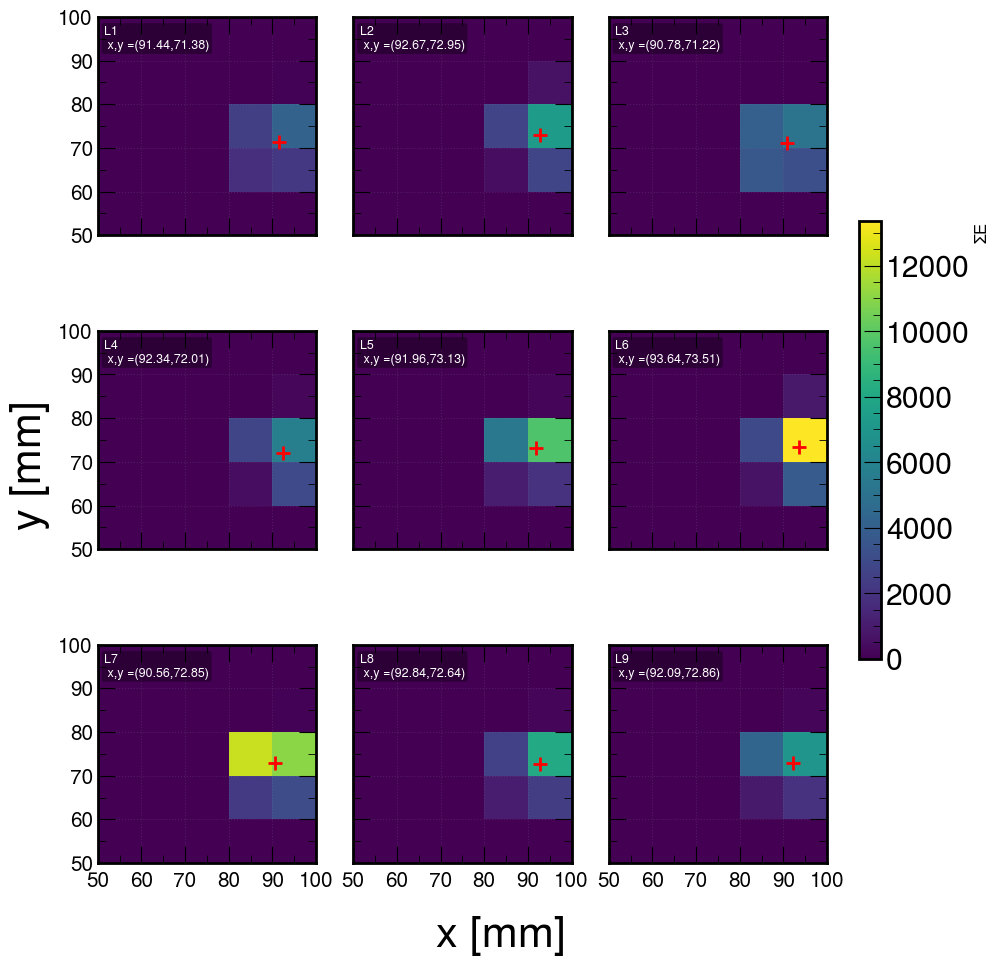

In [14]:
xbins, ybins = 5, 5
xr = (50, 100)
yr = (50, 100)
xedges = np.linspace(*xr, xbins + 1)
yedges = np.linspace(*yr, ybins + 1)

def plot_centroids(x,y, energy_weights=False):
    use_energy_weights = energy_weights
    layers = np.unique(L)
    if layers.size == 0:
        raise RuntimeError("No hits in the chosen ROI!")

    Hmax = 0.0
    for Lk in layers:
        m = (L == Lk)
        if not np.any(m):
            continue
        w = E[m] if use_energy_weights else np.ones(np.count_nonzero(m))
        H, _, _ = np.histogram2d(x[m], y[m], bins=[xedges, yedges], weights=w)
        Hmax = max(Hmax, float(H.max()))
    Hmax = Hmax if Hmax > 0 else 1.0

    n = len(layers)
    cols = min(5, max(3, int(np.ceil(np.sqrt(n)))))
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(
        rows, cols, figsize=(3.3*cols, 3.3*rows),
        sharex=True, sharey=True, constrained_layout=True
    )
    axes = np.atleast_2d(axes)

    pcm_last = None
    for i, Lk in enumerate(layers):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        m = (L == Lk)
        N = int(np.count_nonzero(m))
        if N == 0:
            ax.axis("off")
            continue

        # 2D hist
        w = E[m] if use_energy_weights else np.ones(N)
        H, _, _ = np.histogram2d(x[m], y[m], bins=[xedges, yedges], weights=w)
        pcm_last = ax.pcolormesh(xedges, yedges, H.T, shading="auto", vmin=0, vmax=Hmax)

        # energy-weighted centroid
        xc = np.average(x[m], weights=E[m])
        yc = np.average(y[m], weights=E[m])
        ax.plot(xc, yc, marker="+", ms=10, mew=2, color="red")

        ax.text(0.03, 0.96,
                f"L{Lk}\n⟨x,y⟩=({xc:.2f},{yc:.2f})",
                transform=ax.transAxes, ha="left", va="top",
                fontsize=9, color="w",
                bbox=dict(facecolor=(0,0,0,0.35), edgecolor="none", boxstyle="round,pad=0.2"))

        # aesthetics
        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, alpha=0.15)

    # turn off any unused panels
    total = rows * cols
    for j in range(i+1, total):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    # labels
    for ax in axes.flat:
        ax.set_xlim(xr); ax.set_ylim(yr)
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_minor_locator(MultipleLocator(5))
        ax.yaxis.set_minor_locator(MultipleLocator(5))
        ax.tick_params(labelsize=15)

    fig.supxlabel('x [mm]')
    fig.supylabel('y [mm]')

    # single shared colorbar
    cbar = fig.colorbar(pcm_last, ax=axes, fraction=0.03, pad=0.02)
    cbar.set_label("ΣE" if use_energy_weights else "Counts", fontsize=12)

    plt.show()

plot_centroids(x, y, True)



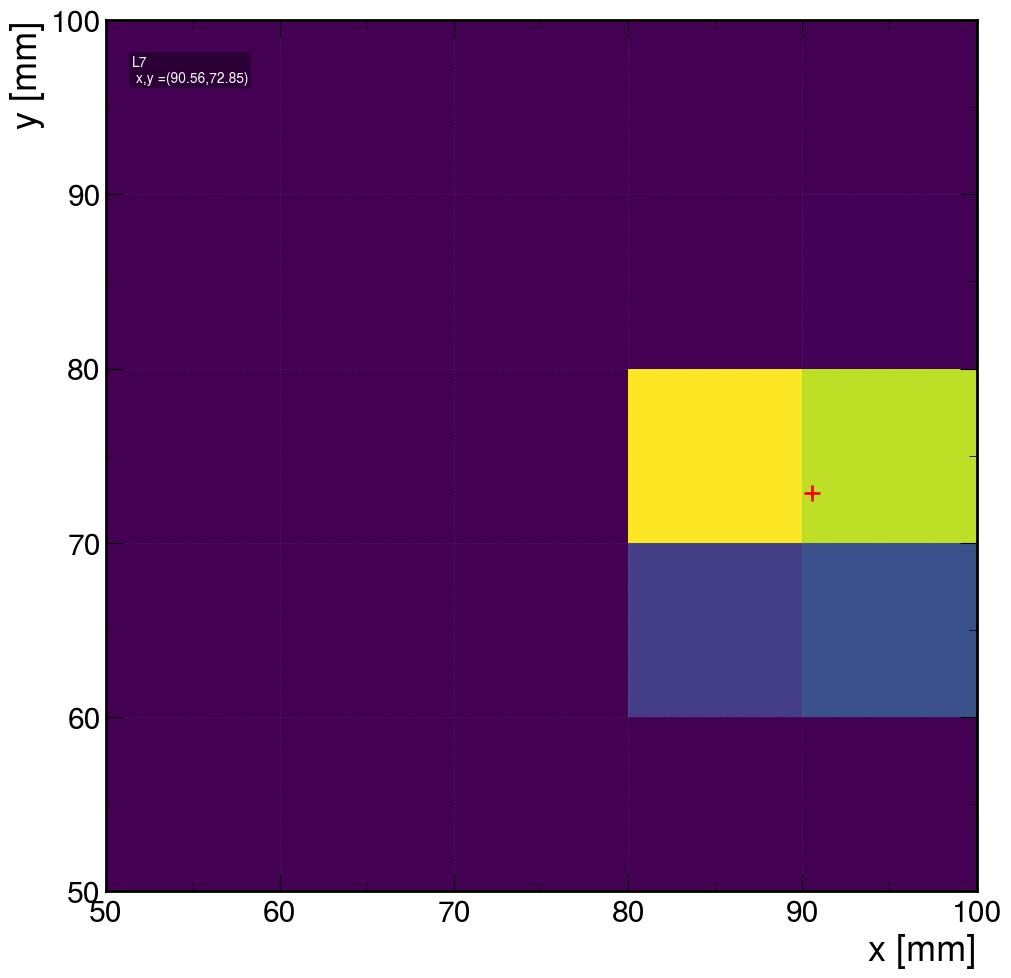

In [15]:

Lk = 7
mask = (L == Lk)
if not np.any(mask):
    raise RuntimeError(f"No hits found in layer {Lk}")

# 2D histogram parameters
xbins, ybins = 5, 5
xr = (50, 100)
yr = (50, 100)
xedges = np.linspace(*xr, xbins + 1)
yedges = np.linspace(*yr, ybins + 1)

# Choose weighting 
use_energy_weights = True
w = E[mask] if use_energy_weights else np.ones(np.count_nonzero(mask))
H, _, _ = np.histogram2d(x[mask], y[mask], bins=[xedges, yedges], weights=w)

# Plot
fig, ax = plt.subplots(constrained_layout=True)
pcm = ax.pcolormesh(xedges, yedges, H.T, shading="auto")

# Energy-weighted centroid
xc = np.average(x[mask], weights=E[mask])
yc = np.average(y[mask], weights=E[mask])
ax.plot(xc, yc, marker="+", ms=12, mew=2, color="red")

ax.text(0.03, 0.96, f"L{Lk}\n⟨x,y⟩=({xc:.2f},{yc:.2f})",
        transform=ax.transAxes, ha="left", va="top", color="w",
        fontsize=10, bbox=dict(facecolor=(0,0,0,0.35), edgecolor="none", boxstyle="round,pad=0.2"))

ax.grid(True, alpha=0.15)

ax.set_xlim(xr)
ax.set_ylim(yr)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
# ax.tick_params(labelsize=14)

# cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
# cbar.set_label("ΣE" if use_energy_weights else "Counts", fontsize=12)

plt.show()

In [16]:
def linear_fit(x,y):
    popt = np.polyfit(x,y,deg=1)
    lin = popt[0]*x + popt[1]
    absres = y - lin
    return popt, lin, absres

def linear_fit_shared(x1, y1, x2, y2, w1=None, w2=None):

    x1 = np.asarray(x1); y1 = np.asarray(y1)
    x2 = np.asarray(x2); y2 = np.asarray(y2)

    A = np.vstack([
        np.r_[x1,                x2               ],
        np.r_[np.ones_like(x1),  np.zeros_like(x2)],
        np.r_[np.zeros_like(x1), np.ones_like(x2) ]
    ]).T
    y = np.r_[y1, y2]

    if w1 is None and w2 is None:
        coef, *_ = np.linalg.lstsq(A, y, rcond=None)
    else:
        if w1 is None: w1 = np.ones_like(y1)
        if w2 is None: w2 = np.ones_like(y2)
        w = np.r_[w1, w2]
        W = np.sqrt(w)[:, None]
        coef, *_ = np.linalg.lstsq(W * A, W * y, rcond=None)

    a, b1, b2 = coef
    y1fit = a*x1 + b1
    y2fit = a*x2 + b2
    res1  = y1 - y1fit
    res2  = y2 - y2fit
    return (a, b1, b2), y1fit, y2fit, res1, res2

def chi2_ndof(res, sigma, n_params):
    res = np.asarray(res); sigma = np.asarray(sigma)
    m = np.isfinite(res) & np.isfinite(sigma) & (sigma > 0)
    if m.sum() <= n_params:
        return np.nan, 0, 0  # not enough points
    chi2 = np.sum((res[m]/sigma[m])**2)
    ndof = m.sum() - n_params
    return chi2/ndof, chi2, ndof


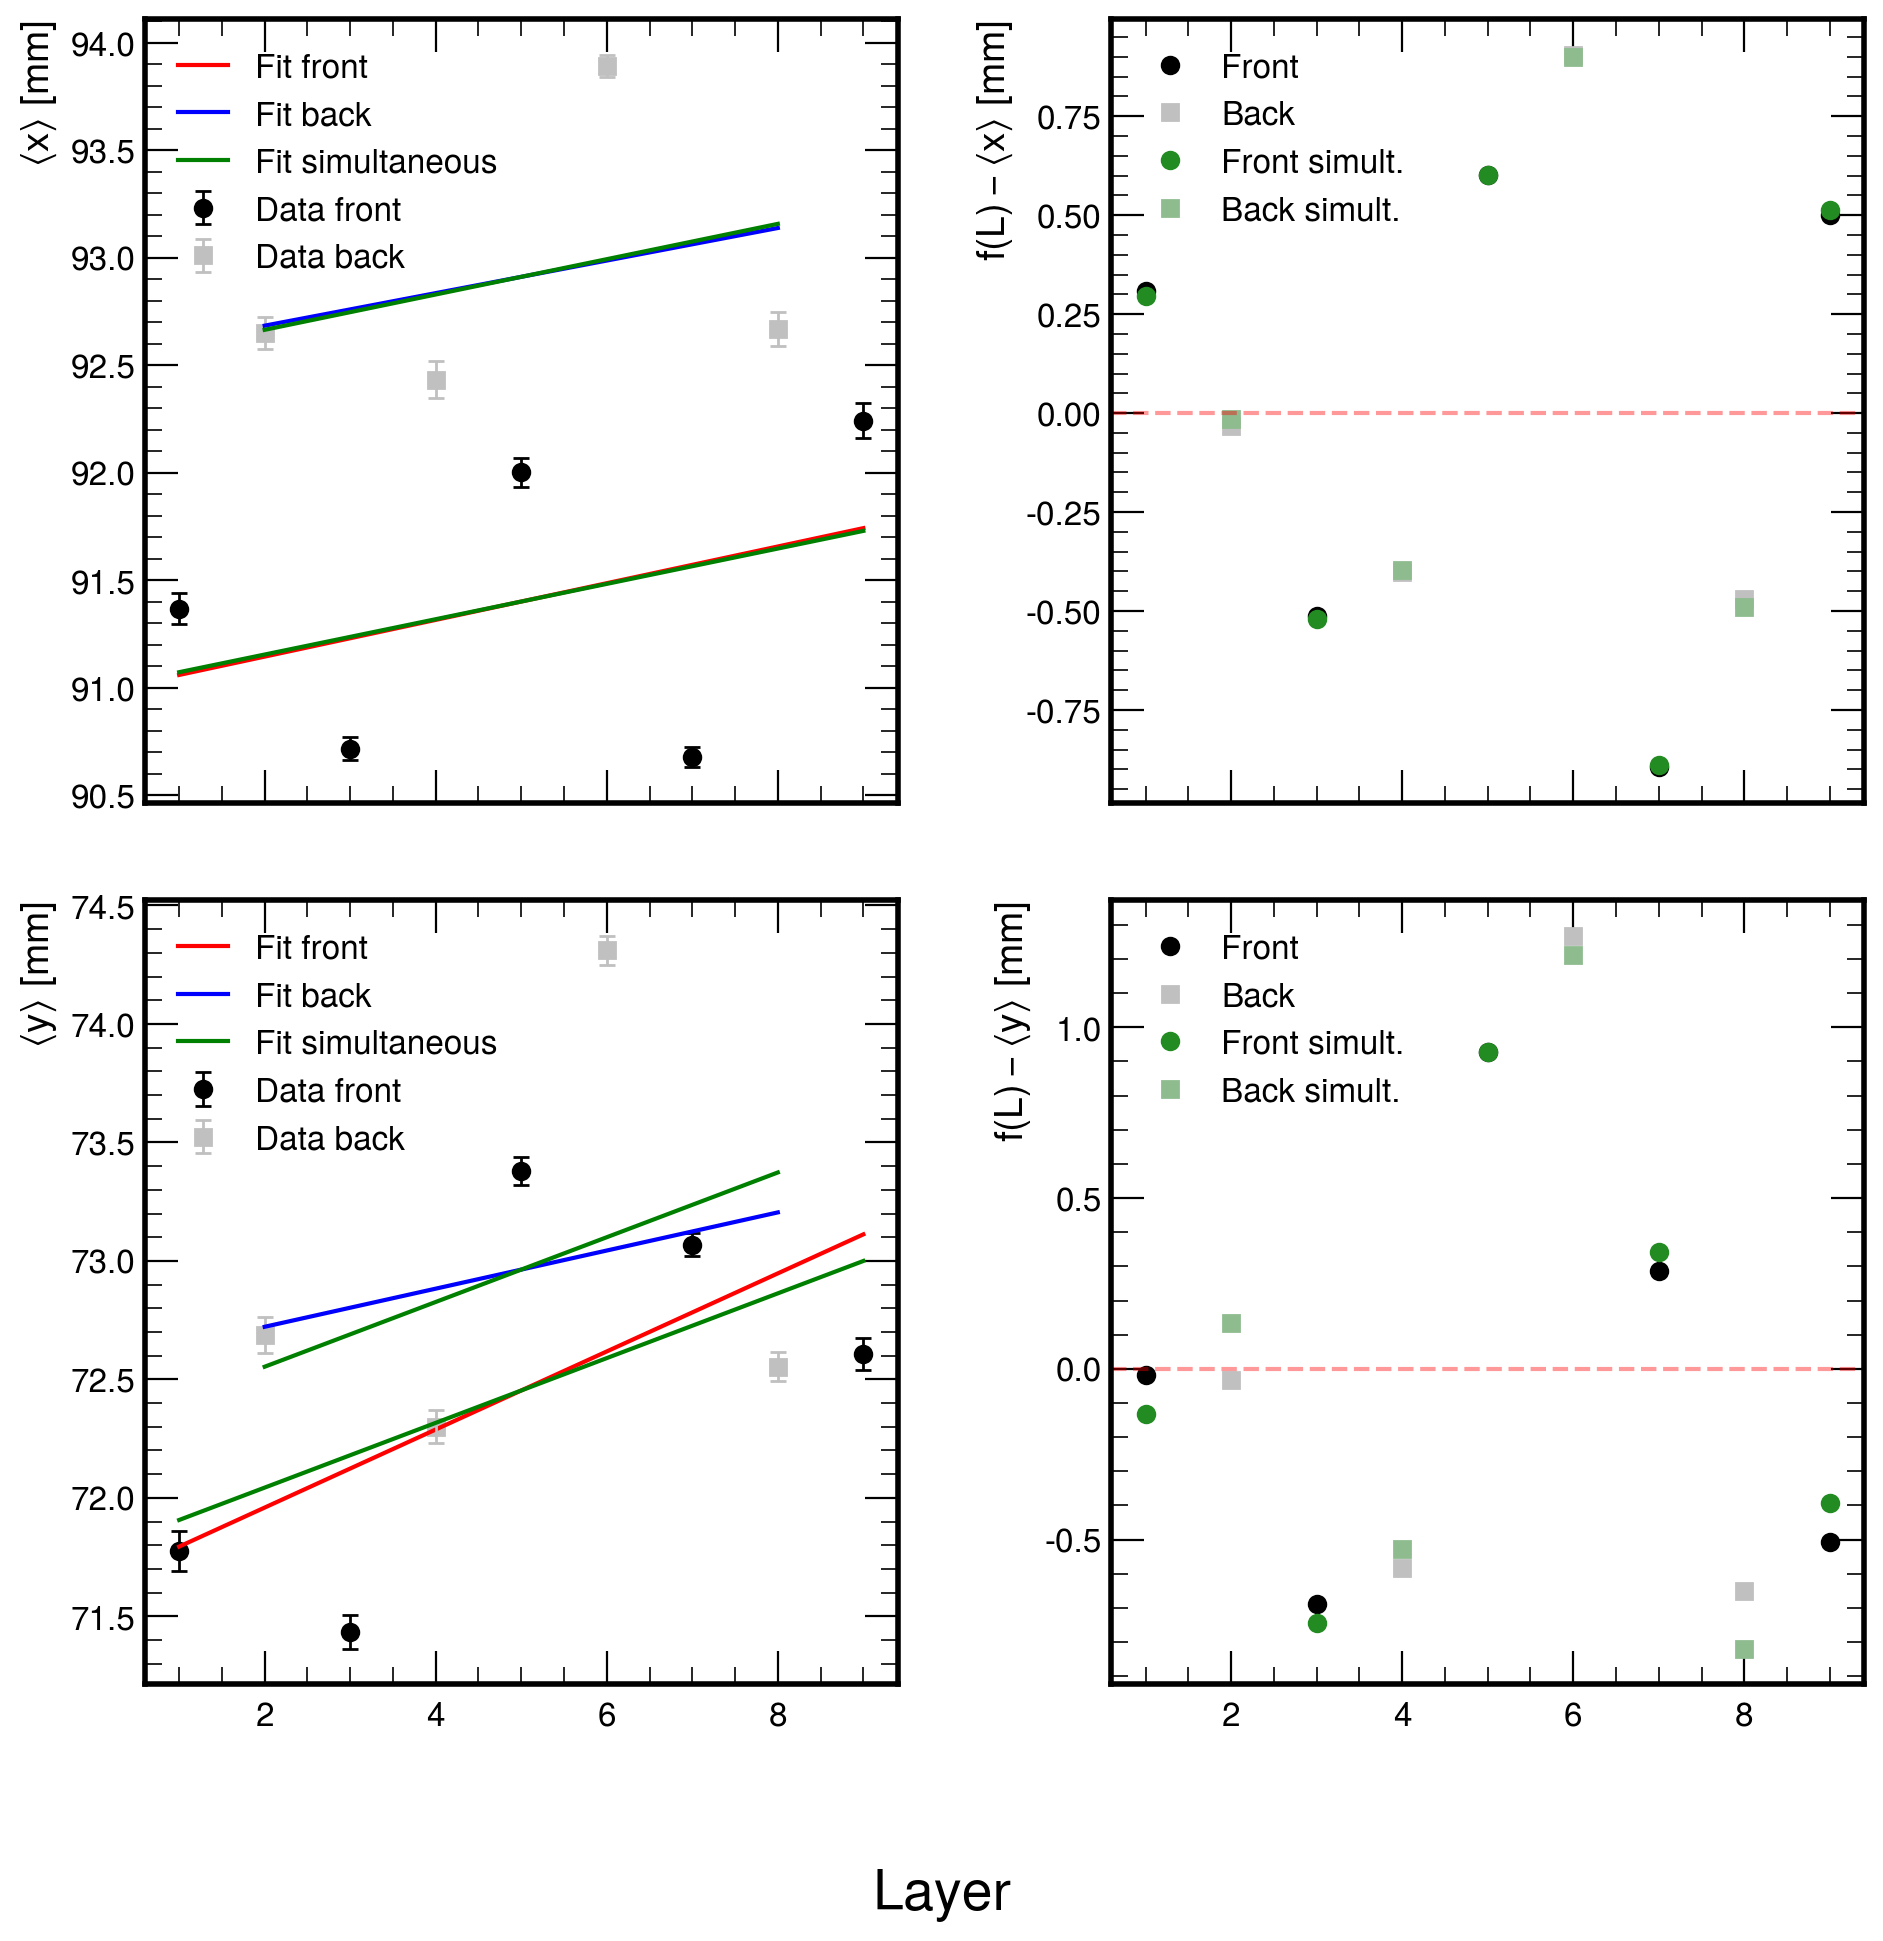

In [17]:
# front and back 
run_key = next(iter(C_by_run))
C_front = C_by_run[run_key]["front"]
C_back  = C_by_run[run_key]["back"]

orderF, orderB = np.argsort(C_front['L']), np.argsort(C_back['L']), 
layers_F, layers_B = C_front['L'][orderF], C_back['L'][orderB]
xF, yF = C_front['xc'][orderF], C_front['yc'][orderF]
xB, yB = C_back['xc'][orderB], C_back['yc'][orderB]

def sem_per_layer(x, y, E, L, side_mask, layers_sorted):
    sx, sy = [], []
    for Lk in layers_sorted:
        m = (L == Lk) & side_mask
        N = int(np.count_nonzero(m))
        if N > 1:
            sx.append(np.nanstd(x[m], ddof=1) / np.sqrt(N))
            sy.append(np.nanstd(y[m], ddof=1) / np.sqrt(N))
        else:
            sx.append(np.nan)
            sy.append(np.nan)
    return np.array(sx), np.array(sy)

is_front = (L % 2) == 1
m_front, m_back = is_front, ~is_front
sigma_xF, sigma_yF = sem_per_layer(x, y, E, L, m_front, layers_F)
sigma_xB, sigma_yB = sem_per_layer(x, y, E, L, m_back, layers_B)

# fits 
poptx_F, fitx_F, resx_F = linear_fit(layers_F, xF)
popty_F, fity_F, resy_F = linear_fit(layers_F, yF)

poptx_B, fitx_B, resx_B = linear_fit(layers_B, xB)
popty_B, fity_B, resy_B = linear_fit(layers_B, yB)

# goodness-of-fit
chi2nd_xF, _, _ = chi2_ndof(resx_F, sigma_xF, n_params=2)
chi2nd_xB, _, _ = chi2_ndof(resx_B, sigma_xB, n_params=2)
chi2nd_yF, _, _ = chi2_ndof(resy_F, sigma_yF, n_params=2)
chi2nd_yB, _, _ = chi2_ndof(resy_B, sigma_yB, n_params=2)

# simultaneous fit
(ax, bxF, bxB), xFfit, xBfit, rxF, rxB = linear_fit_shared(layers_F, xF, layers_B, xB)
(ay, byF, byB), yFfit, yBfit, ryF, ryB = linear_fit_shared(layers_F, yF, layers_B, yB)

# goodness-of-fit
chi2nd_simx, chi2_simx, ndof_simx = chi2_ndof(np.r_[rxF, rxB], np.r_[sigma_xF, sigma_xB], n_params=3)
chi2nd_simy, chi2_simy, ndof_simy = chi2_ndof(np.r_[ryF, ryB], np.r_[sigma_yF, sigma_yB], n_params=3)

DZ_MM = None 

# plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, dpi=200, sharex=True)

# x vs layer
ax1.errorbar(layers_F, xF, yerr=sigma_xF, marker='o', c='black',
             barsabove=True, capsize=3, elinewidth=1, linewidth=0, label='Data front')
ax1.plot(layers_F, fitx_F, c='r', label='Fit front')
ax1.errorbar(layers_B, xB, yerr=sigma_xB, marker='s', c='silver',
             barsabove=True, capsize=3, elinewidth=1, linewidth=0, label='Data back')
ax1.plot(layers_B, fitx_B, c='b', label='Fit back')
ax1.plot(layers_F, xFfit, c='green', label='Fit simultaneous')
ax1.plot(layers_B, xBfit, c='green')

ax1.set_ylabel(r'$\langle x \rangle$ [mm]', fontsize=14)
ax1.legend(frameon=False, fontsize=12, loc="best")
ax1.tick_params(labelsize=12)

if DZ_MM is not None:
    thx = np.arctan(poptx_F[0] / DZ_MM)
    ax1.text(0.03, 0.86, fr"$\theta_x \approx$ {np.degrees(thx):+.2f}$^\circ$ ({1e3*thx:+.1f} mrad)",
             transform=ax1.transAxes, fontsize=12, va="top")

# x residuals
ax2.plot(layers_F, resx_F, marker='o', c='black', linewidth=0, label='Front')
ax2.plot(layers_B, resx_B, marker='s', c='silver', linewidth=0, label='Back')
ax2.plot(layers_F, rxF, marker='o', c='forestgreen', linewidth=0, label = 'Front simult.')
ax2.plot(layers_B, rxB, marker='s', c='darkseagreen', linewidth=0, label = 'Back simult.')
ax2.axhline(0, alpha = 0.4, c='r', linestyle='--')
ax2.set_ylabel(r'$f(L)-\langle x\rangle$ [mm]', fontsize=14)
ax2.tick_params(labelsize=12)
ax2.legend(frameon=False, fontsize=12, loc="best")

# y vs layer
ax3.errorbar(layers_F, yF, yerr=sigma_yF, marker='o', c='black',
             barsabove=True, capsize=3, elinewidth=1, linewidth=0, label='Data front')
ax3.plot(layers_F, fity_F, c='r', label='Fit front')
ax3.errorbar(layers_B, yB, yerr=sigma_yB, marker='s', c='silver',
             barsabove=True, capsize=3, elinewidth=1, linewidth=0, label='Data back')
ax3.plot(layers_B, fity_B, c='b', label=f'Fit back')
ax3.plot(layers_F, yFfit, c='green', label='Fit simultaneous')
ax3.plot(layers_B, yBfit, c='green')

ax3.set_ylabel(r'$\langle y \rangle$ [mm]', fontsize=14)
ax3.legend(frameon=False, fontsize=12, loc="best")
ax3.tick_params(labelsize=12)

if DZ_MM is not None:
    thy = np.arctan(popty_F[0] / DZ_MM)
    ax3.text(0.03, 0.86, fr"$\theta_y \approx$ {np.degrees(thy):+.2f}$^\circ$ ({1e3*thy:+.1f} mrad)",
             transform=ax3.transAxes, fontsize=12, va="top")

# y residuals
ax4.plot(layers_F, resy_F, marker='o', c='black', linewidth=0, label = 'Front')
ax4.plot(layers_B, resy_B, marker='s', c='silver', linewidth=0, label = 'Back')
ax4.plot(layers_F, ryF, marker='o', c='forestgreen', linewidth=0, label = 'Front simult.')
ax4.plot(layers_B, ryB, marker='s', c='darkseagreen', linewidth=0, label = 'Back simult.')
ax4.axhline(0, alpha = 0.4, c='r', linestyle='--')
ax4.set_ylabel(r'$f(L)-\langle y\rangle$ [mm]', fontsize=14)
ax4.tick_params(labelsize=12)
ax4.legend(frameon=False, fontsize=12, loc="best")

fig.supxlabel('Layer', fontsize=20)
fig.tight_layout()
plt.show()


In [18]:
# Map residuals to their layer numbers
run_key = next(iter(C_by_run))
C_front = C_by_run[run_key]["front"]
C_back  = C_by_run[run_key]["back"]
orderF, orderB = np.argsort(C_front['L']), np.argsort(C_back['L']), 
layers_F, layers_B = C_front['L'][orderF], C_back['L'][orderB]
dx = {}
dy = {}
for l, r in zip(layers_F, rxF): dx[int(l)] = float(-r)
for l, r in zip(layers_B, rxB): dx[int(l)] = float(-r)
for l, r in zip(layers_F, ryF): dy[int(l)] = float(-r)
for l, r in zip(layers_B, ryB): dy[int(l)] = float(-r)

# table
print("\nPer-layer corrections (mm):")
for l in sorted(set(list(dx.keys()) + list(dy.keys()))):
    print(f"  L{l:2d}:  dx={dx.get(l,0):+7.3f}   dy={dy.get(l,0):+7.3f}")
    
print()
print(f"χ-sq sim. x: {chi2nd_simx:.2f}")
print(f"χ-sq sim. y: {chi2nd_simy:.2f}")
print()
print(f"χ-sq front x: {chi2nd_xF:.2f}")
print(f"χ-sq back x: {chi2nd_xB:.2f}")
print(f"χ-sq front x: {chi2nd_yF:.2f}")
print(f"χ-sq back x: {chi2nd_yB:.2f}")






Per-layer corrections (mm):
  L 1:  dx= -0.295   dy= +0.131
  L 2:  dx= +0.014   dy= -0.135
  L 3:  dx= +0.520   dy= +0.745
  L 4:  dx= +0.396   dy= +0.527
  L 5:  dx= -0.601   dy= -0.928
  L 6:  dx= -0.899   dy= -1.211
  L 7:  dx= +0.889   dy= -0.342
  L 8:  dx= +0.489   dy= +0.819
  L 9:  dx= -0.512   dy= +0.394

χ-sq sim. x: 154.92
χ-sq sim. y: 179.35

χ-sq front x: 194.30
χ-sq back x: 175.34
χ-sq front x: 142.64
χ-sq back x: 309.43


In [19]:
def offsets_for_layers(d, layers):
    if d is None:
        return np.zeros_like(layers, dtype=float)
    return np.array([float(d.get(int(Lk), 0.0)) for Lk in layers], dtype=float)

def apply_hit_corrections(x, y, L, dx_dict=None, dy_dict=None):
    dxL = offsets_for_layers(dx_dict, L)
    dyL = offsets_for_layers(dy_dict, L)
    return x + dxL, y + dyL

import numpy as np

def centroids_by_layer(x, y, E, L, layer_order=None, return_counts=False, min_hits=1):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    E = np.asarray(E, dtype=float)
    L = np.asarray(L)

    # Finite mask (ignore bad rows)
    mfin = np.isfinite(x) & np.isfinite(y) & np.isfinite(E) & np.isfinite(L)
    if not np.any(mfin):
        layers = np.array([], dtype=int) if layer_order is None else np.asarray(layer_order, dtype=int)
        xc = np.full(layers.shape, np.nan)
        yc = np.full(layers.shape, np.nan)
        if return_counts:
            N = np.zeros_like(layers, dtype=int)
            return layers, xc, yc, N
        return layers, xc, yc

    x, y, E, L = x[mfin], y[mfin], E[mfin], L[mfin].astype(int)

    # Decide output layer list/order
    if layer_order is None:
        layers = np.unique(L)
    else:
        layers = np.asarray(layer_order, dtype=int)

    K = layers.size
    if K == 0:
        xc = yc = np.array([], dtype=float)
        if return_counts:
            return layers, xc, yc, np.array([], dtype=int)
        return layers, xc, yc

    # Map arbitrary layer IDs -> [0..K-1] bins
    idx_map = {ell: i for i, ell in enumerate(layers)}
    idx = np.fromiter((idx_map.get(int(ell), -1) for ell in L), count=L.size, dtype=int)
    mvalid = (idx >= 0) & np.isfinite(E)

    if not np.any(mvalid):
        xc = np.full(K, np.nan)
        yc = np.full(K, np.nan)
        N  = np.zeros(K, dtype=int)
        if return_counts:
            return layers, xc, yc, N
        return layers, xc, yc

    idx = idx[mvalid]
    xv  = x[mvalid]
    yv  = y[mvalid]
    Ev  = E[mvalid]

    # Aggregate with bincount
    sum_w   = np.bincount(idx, weights=Ev, minlength=K)
    sum_xw  = np.bincount(idx, weights=Ev * xv, minlength=K)
    sum_yw  = np.bincount(idx, weights=Ev * yv, minlength=K)
    counts  = np.bincount(idx, minlength=K).astype(int)

    # Centroids; guard against zero weight or too few hits
    xc = np.full(K, np.nan, dtype=float)
    yc = np.full(K, np.nan, dtype=float)

    good = (sum_w > 0) & (counts >= int(min_hits))
    xc[good] = sum_xw[good] / sum_w[good]
    yc[good] = sum_yw[good] / sum_w[good]

    if return_counts:
        return layers, xc, yc, counts
    return layers, xc, yc

    

In [20]:
xcorr, ycorr = apply_hit_corrections(x,y,L,dx,dy)
mF = (L % 2 == 1)
mB = ~mF

C_corr, accepted_corr = collect_muons_and_centroids(
    all_files[:10], roi=(50,100,50,100), step_size="40 MB",
    keep_event_ids=True,
    dx_dict=dx, dy_dict=dy, 
)

max |residual_x| (sim fit): 0.25638299672321807
max |residual_y| (sim fit): 0.7993683450456786


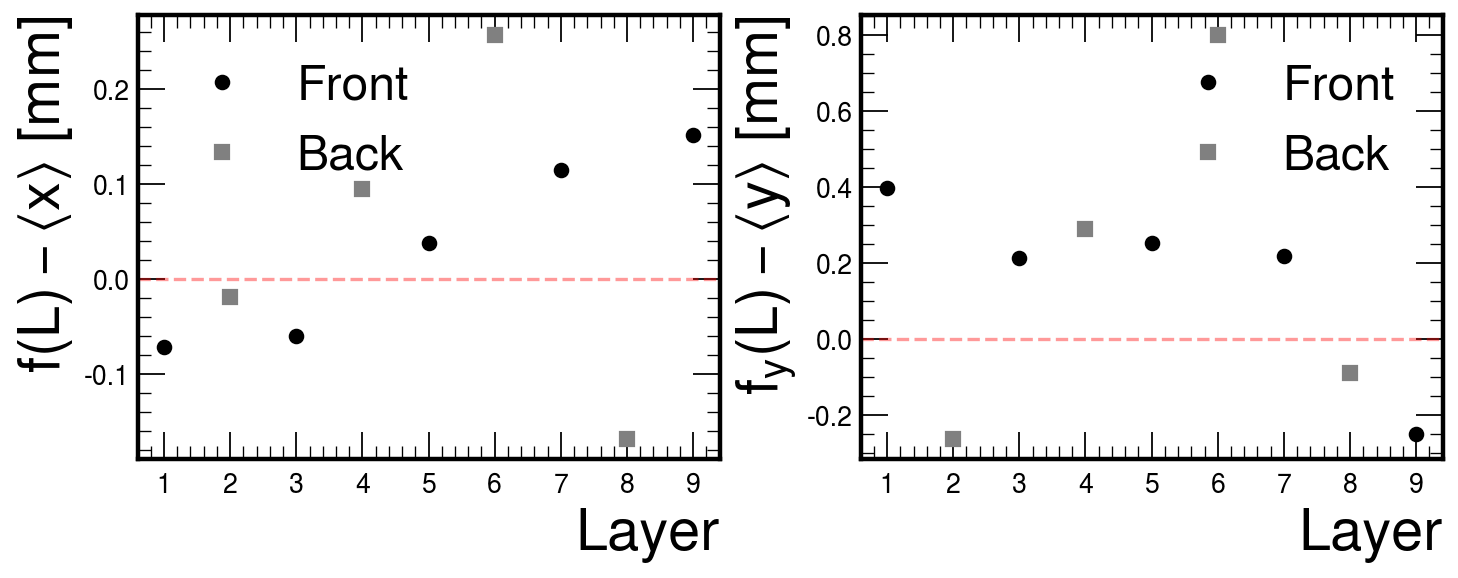

In [21]:

Lmin, Lmax = int(L.min()), int(L.max())
front_layers = [ell for ell in range(Lmin, Lmax + 1) if ell % 2 == 1]  # odd
back_layers  = [ell for ell in range(Lmin, Lmax + 1) if ell % 2 == 0]  # even


LF, xF_c, yF_c, NF = centroids_by_layer(
    xcorr[mF], ycorr[mF], E[mF], L[mF],
    layer_order=front_layers, return_counts=True
)
LB, xB_c, yB_c, NB = centroids_by_layer(
    xcorr[mB], ycorr[mB], E[mB], L[mB],
    layer_order=back_layers, return_counts=True
)

def _eval_fit(f_or_arr, layers):
    if callable(f_or_arr):
        return np.asarray(f_or_arr(layers), dtype=float)
    try:
        return np.asarray([f_or_arr[int(i)] for i in layers], dtype=float)
    except Exception:
        return np.asarray(f_or_arr, dtype=float)
    
xF_fit = _eval_fit(xFfit, LF); xB_fit = _eval_fit(xBfit, LB)
yF_fit = _eval_fit(yFfit, LF); yB_fit = _eval_fit(yBfit, LB)

rxF_new = xF_fit - xF_c
rxB_new = xB_fit - xB_c
ryF_new = yF_fit - yF_c
ryB_new = yB_fit - yB_c

print("max |residual_x| (sim fit):", np.nanmax(np.abs(np.r_[rxF_new, rxB_new])))
print("max |residual_y| (sim fit):", np.nanmax(np.abs(np.r_[ryF_new, ryB_new])))

# plot
fig, ax = plt.subplots(1, 2, figsize=(9,3.5), dpi=160, constrained_layout=True)

for a in ax:
    a.axhline(0, ls="--", c="r", alpha=0.4)
    a.xaxis.set_major_locator(MaxNLocator(integer=True)) 
# X residuals
ax[0].plot(LF, rxF_new, "o", label="Front", color="black")
ax[0].plot(LB, rxB_new, "s", label="Back", color="gray")
ax[0].set_xlabel("Layer")
ax[0].set_ylabel(r"$f(L) - \langle x\rangle$ [mm]")
ax[0].legend(frameon=False)
ax[0].tick_params(labelsize=12)

# Y residuals
ax[1].plot(LF, ryF_new, "o", label="Front", color="black")
ax[1].plot(LB, ryB_new, "s", label="Back", color="gray")
ax[1].set_xlabel("Layer")
ax[1].set_ylabel(r"$f_y(L) - \langle y\rangle$ [mm]")
ax[1].legend(frameon=False)
ax[1].tick_params(labelsize=12)

plt.show()


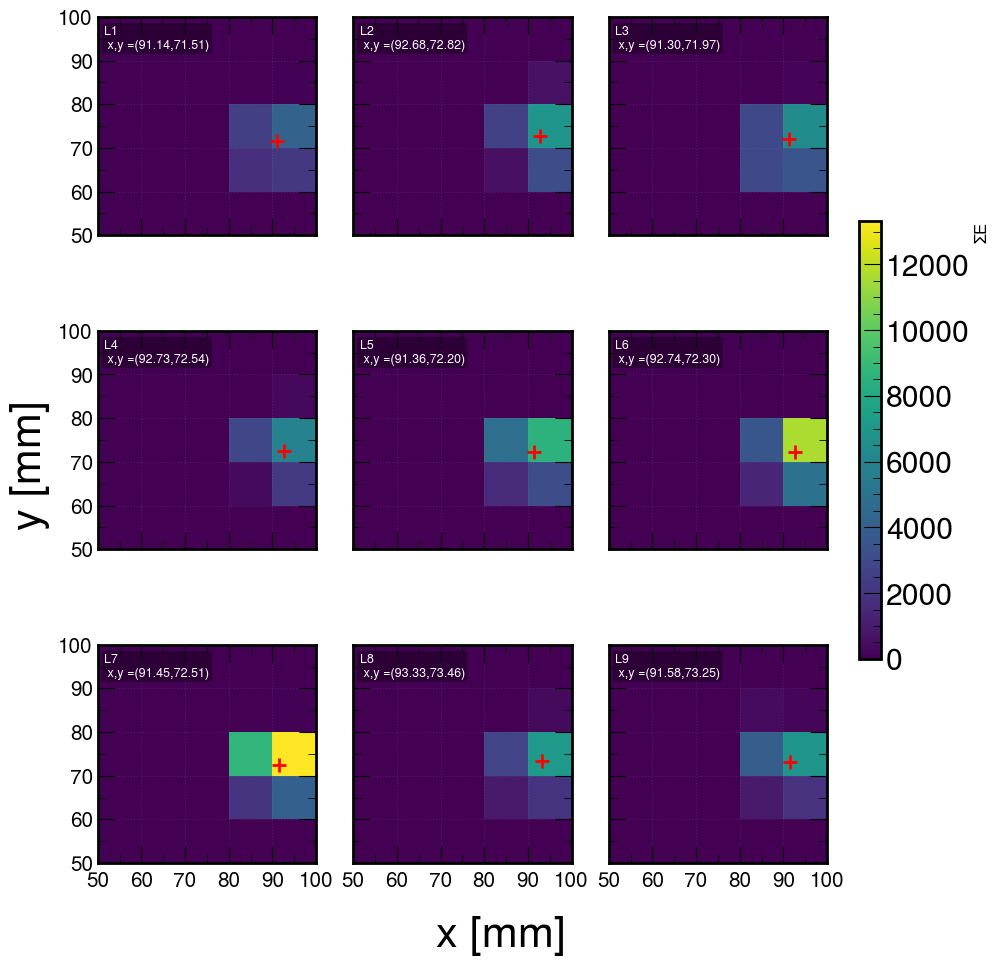

In [22]:
plot_centroids(xcorr, ycorr, True)

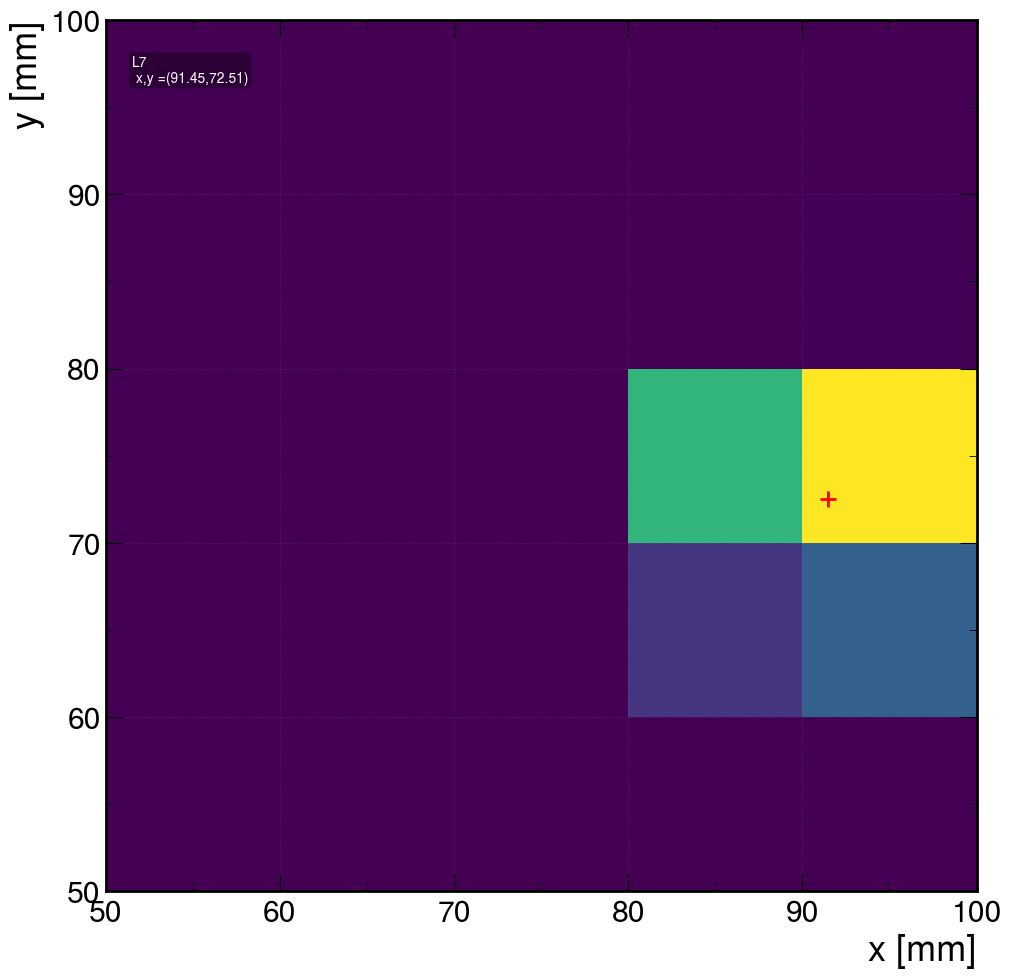

In [23]:

Lk = 7
mask = (L == Lk)
if not np.any(mask):
    raise RuntimeError(f"No hits found in layer {Lk}")

xbins, ybins = 5, 5
xr = (50, 100)
yr = (50, 100)
xedges = np.linspace(*xr, xbins + 1)
yedges = np.linspace(*yr, ybins + 1)

use_energy_weights = True
w = E[mask] if use_energy_weights else np.ones(np.count_nonzero(mask))
H, _, _ = np.histogram2d(xcorr[mask], ycorr[mask], bins=[xedges, yedges], weights=w)

fig, ax = plt.subplots(constrained_layout=True)
pcm = ax.pcolormesh(xedges, yedges, H.T, shading="auto")

xc = np.average(xcorr[mask], weights=E[mask])
yc = np.average(ycorr[mask], weights=E[mask])
ax.plot(xc, yc, marker="+", ms=12, mew=2, color="red")

ax.text(0.03, 0.96, f"L{Lk}\n⟨x,y⟩=({xc:.2f},{yc:.2f})",
        transform=ax.transAxes, ha="left", va="top", color="w",
        fontsize=10, bbox=dict(facecolor=(0,0,0,0.35), edgecolor="none", boxstyle="round,pad=0.2"))

ax.grid(True, alpha=0.15)

ax.set_xlim(xr)
ax.set_ylim(yr)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
# ax.tick_params(labelsize=14)

# cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
# cbar.set_label("ΣE" if use_energy_weights else "Counts", fontsize=12)

plt.show()

mean |ΔxF - dx|: 4.588986723774724e-06
mean |ΔxB - dx|: 2.889236636605119e-06
mean |ΔyF - dy|: 8.820477688686878e-07
mean |ΔyB - dy|: 2.850314455571379e-06
RMS_x Front  before/after: 0.5949249665524141 5.708843346682583e-06
RMS_x Back   before/after: 0.43608848904167274 3.127420230753021e-06
RMS_y Front  before/after: 0.5267179400606995 1.0859786115786348e-06
RMS_y Back   before/after: 0.615542285930627 3.121529466408938e-06


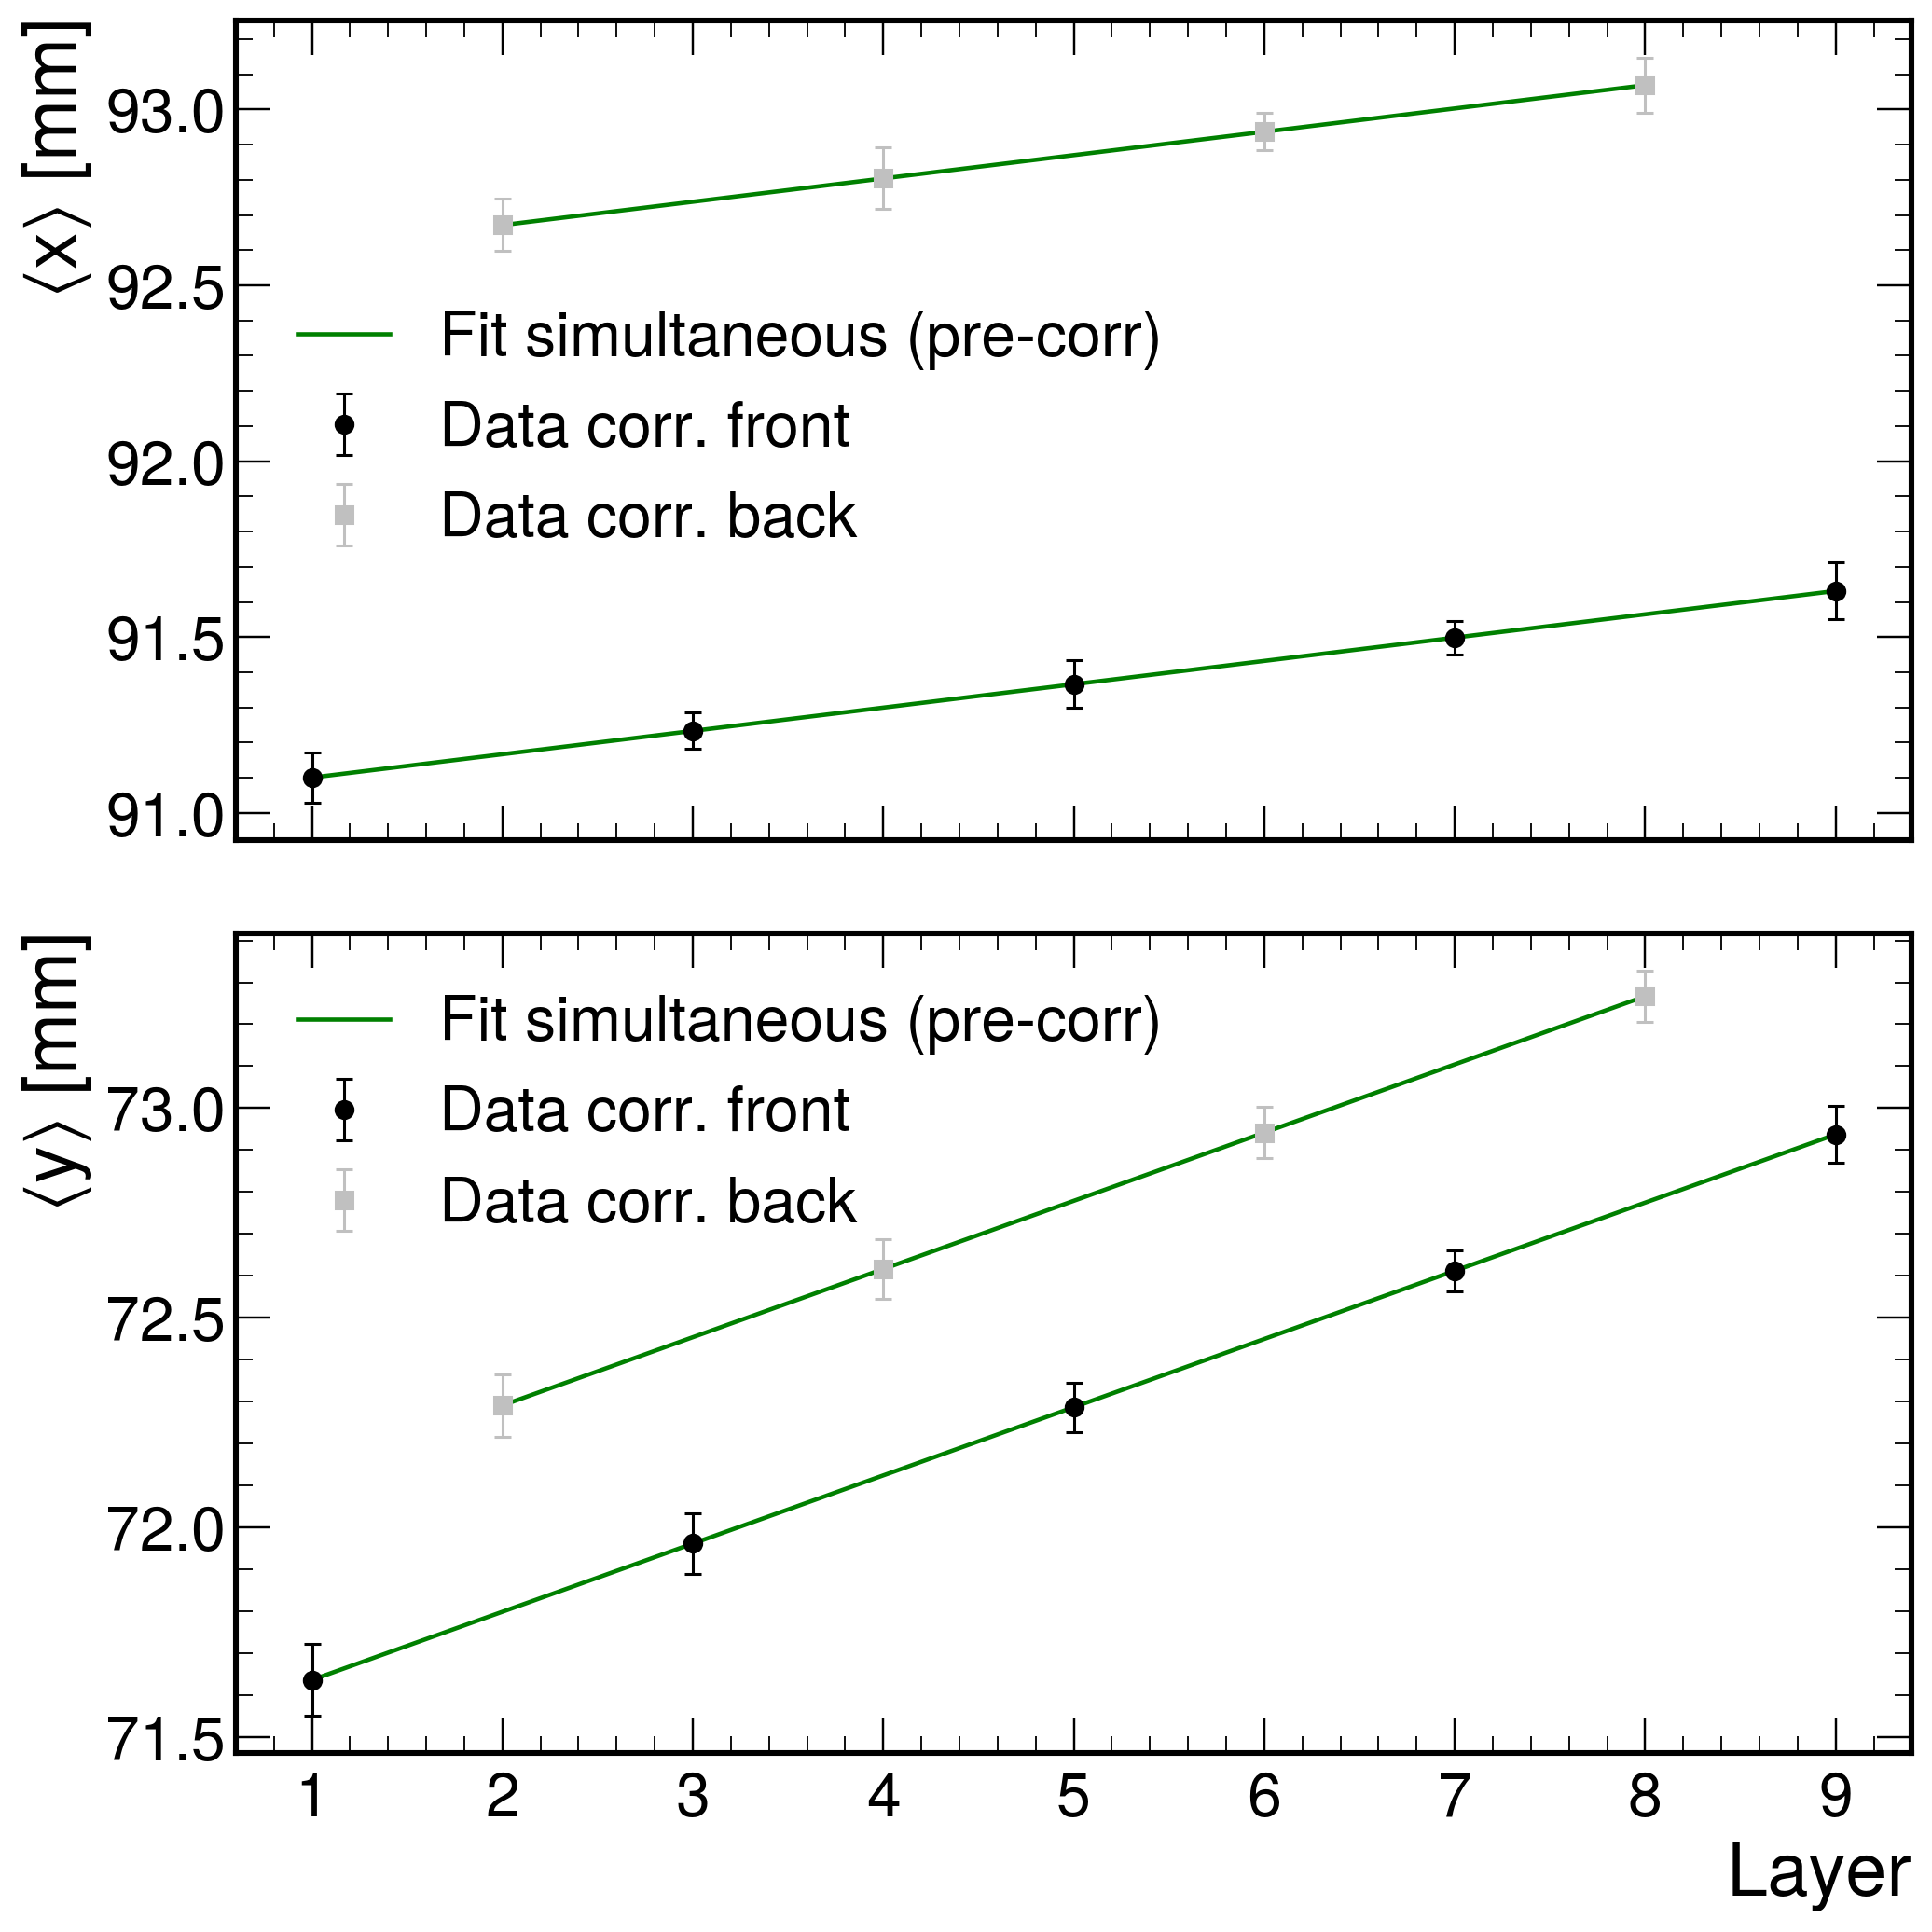

In [24]:

runs = {"112147","112148","112149"}
by_run = find_nano_files_grouped(base, runs, max_per_run=10)
all_files = [f for rr in runs for f in by_run[str(rr)]]

ROI = (50,100,50,100)
STEP = "40 MB"
DROP_LAYER = 10


C_before, accepted_before = collect_muons_and_centroids(
    all_files, roi=ROI, drop_layer=DROP_LAYER, step_size=STEP,
    keep_event_ids=True, dx_dict=None, dy_dict=None
)

# pick a run
rk = next(iter(C_before.keys()))
Fb = C_before[rk]["front"]; Bb = C_before[rk]["back"]

# sorted layer arrays
orderF = np.argsort(Fb["L"]); orderB = np.argsort(Bb["L"])
LF = Fb["L"][orderF]; LB = Bb["L"][orderB]
xF0, yF0 = Fb["xc"][orderF], Fb["yc"][orderF]
xB0, yB0 = Bb["xc"][orderB], Bb["yc"][orderB]


(a_x, bF_x, bB_x), xFfit, xBfit, rxF, rxB = linear_fit_shared(LF, xF0, LB, xB0)
(a_y, bF_y, bB_y), yFfit, yBfit, ryF, ryB = linear_fit_shared(LF, yF0, LB, yB0)


dx = {int(Lk): float(-r) for Lk, r in zip(LF, rxF)}
dx.update({int(Lk): float(-r) for Lk, r in zip(LB, rxB)})
dy = {int(Lk): float(-r) for Lk, r in zip(LF, ryF)}
dy.update({int(Lk): float(-r) for Lk, r in zip(LB, ryB)})

C_after, accepted_after = collect_muons_and_centroids(
    all_files, roi=ROI, drop_layer=DROP_LAYER, step_size=STEP,
    keep_event_ids=True, dx_dict=dx, dy_dict=dy
)

Fa = C_after[rk]["front"]; Ba = C_after[rk]["back"]
orderF2 = np.argsort(Fa["L"]); orderB2 = np.argsort(Ba["L"])
# enforce identical layer order as BEFORE
assert np.array_equal(LF, Fa["L"][orderF2]) and np.array_equal(LB, Ba["L"][orderB2])

xF1, yF1 = Fa["xc"][orderF2], Fa["yc"][orderF2]
xB1, yB1 = Ba["xc"][orderB2], Ba["yc"][orderB2]

dxF = np.array([dx.get(int(l), 0.0) for l in LF], float)
dxB = np.array([dx.get(int(l), 0.0) for l in LB], float)
dyF = np.array([dy.get(int(l), 0.0) for l in LF], float)
dyB = np.array([dy.get(int(l), 0.0) for l in LB], float)

def mean_abs(a):
    a = np.asarray(a); m = np.isfinite(a)
    return float(np.nanmean(np.abs(a[m])))

print("mean |ΔxF - dx|:", mean_abs((xF1 - xF0) - dxF))
print("mean |ΔxB - dx|:", mean_abs((xB1 - xB0) - dxB))
print("mean |ΔyF - dy|:", mean_abs((yF1 - yF0) - dyF))
print("mean |ΔyB - dy|:", mean_abs((yB1 - yB0) - dyB))

rxF_before = xFfit - xF0; rxB_before = xBfit - xB0
ryF_before = yFfit - yF0; ryB_before = yBfit - yB0

rxF_after  = xFfit - xF1; rxB_after  = xBfit - xB1
ryF_after  = yFfit - yF1; ryB_after  = yBfit - yB1

def rms(a): 
    a = np.asarray(a); m = np.isfinite(a)
    return float(np.sqrt(np.nanmean(a[m]**2)))

print("RMS_x Front  before/after:", rms(rxF_before), rms(rxF_after))
print("RMS_x Back   before/after:", rms(rxB_before), rms(rxB_after))
print("RMS_y Front  before/after:", rms(ryF_before), rms(ryF_after))
print("RMS_y Back   before/after:", rms(ryB_before), rms(ryB_after))

mF = (L % 2 == 1)
mB = ~mF

sigma_xF, sigma_yF = sem_per_layer(xcorr, ycorr, E, L, mF, LF)
sigma_xB, sigma_yB = sem_per_layer(xcorr, ycorr, E, L, mB, LB)

fig, (ax1, ax3) = plt.subplots(2, 1, dpi=220, sharex=True)

ax1.plot(LF, xFfit, c='green', label='Fit simultaneous (pre-corr)')
ax1.plot(LB, xBfit, c='green')
ax1.errorbar(LF, xF1, yerr=sigma_xF, fmt='o', color='black', capsize=3, lw=1, label='Data corr. front')
ax1.errorbar(LB, xB1, yerr=sigma_xB, fmt='s', color='silver', capsize=3, lw=1, label='Data corr. back')
ax1.set_ylabel(r'$\langle x \rangle$ [mm]'); ax1.legend(frameon=False)

ax3.plot(LF, yFfit, c='green', label='Fit simultaneous (pre-corr)')
ax3.plot(LB, yBfit, c='green')
ax3.errorbar(LF, yF1, yerr=sigma_yF, fmt='o', color='black', capsize=3, lw=1, label='Data corr. front')
ax3.errorbar(LB, yB1, yerr=sigma_yB, fmt='s', color='silver', capsize=3, lw=1, label='Data corr. back')
ax3.set_ylabel(r'$\langle y \rangle$ [mm]'); ax3.set_xlabel('Layer'); ax3.legend(frameon=False)

plt.tight_layout(); plt.show()

